In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the base path to your dataset folder
base_path = r'C:\Users\abhis\ML-PROJECT\posture-correction\dataset'

# Construct the full paths to each CSV file
file_paths = {
    'labels': os.path.join(base_path, 'labels.csv'),
    'angles': os.path.join(base_path, 'angles.csv'),
    '3d_distances': os.path.join(base_path, '3d_distances.csv'),
    'xyz_distances': os.path.join(base_path, 'xyz_distances.csv'),
    'landmarks': os.path.join(base_path, 'landmarks.csv')
}

# Load the datasets
try:
    df_labels = pd.read_csv(file_paths['labels'])
    df_angles = pd.read_csv(file_paths['angles'])
    df_3d_distances = pd.read_csv(file_paths['3d_distances'])
    df_xyz_distances = pd.read_csv(file_paths['xyz_distances'])
    df_landmarks = pd.read_csv(file_paths['landmarks'])
    
    # Merge the datasets
    df_master = df_labels.copy()
    df_master = pd.merge(df_master, df_angles, on='pose_id', how='left')
    df_master = pd.merge(df_master, df_3d_distances, on='pose_id', how='left')
    
    print("Master DataFrame Info:")
    df_master.info()
    print("\nFirst 5 rows of the merged data:")
    print(df_master.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Please double-check the path to your dataset folder.")

Master DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   pose_id                                 1372 non-null   int64  
 1   pose                                    1372 non-null   object 
 2   right_elbow_right_shoulder_right_hip    1372 non-null   float64
 3   left_elbow_left_shoulder_left_hip       1372 non-null   float64
 4   right_knee_mid_hip_left_knee            1372 non-null   float64
 5   right_hip_right_knee_right_ankle        1372 non-null   float64
 6   left_hip_left_knee_left_ankle           1372 non-null   float64
 7   right_wrist_right_elbow_right_shoulder  1372 non-null   float64
 8   left_wrist_left_elbow_left_shoulder     1372 non-null   float64
 9   left_shoulder_left_wrist                1372 non-null   float64
 10  right_shoulder_right_wrist           

In [4]:
# Statistical summary of numerical features
print("\n--- Statistical Summary of Features ---")
print(df_master.describe())

# Distribution of the target variable ('pose')
print("\n--- Distribution of Posture Poses ---")
print(df_master['pose'].value_counts())


--- Statistical Summary of Features ---
           pose_id  right_elbow_right_shoulder_right_hip  \
count  1372.000000                           1372.000000   
mean    685.500000                             80.316861   
std     396.206596                             49.725287   
min       0.000000                              2.219555   
25%     342.750000                             37.261593   
50%     685.500000                             73.127522   
75%    1028.250000                            124.200839   
max    1371.000000                            179.786010   

       left_elbow_left_shoulder_left_hip  right_knee_mid_hip_left_knee  \
count                        1372.000000                   1372.000000   
mean                           80.704825                     46.253607   
std                            49.229523                     28.837127   
min                             3.543095                      2.154495   
25%                            39.241775        

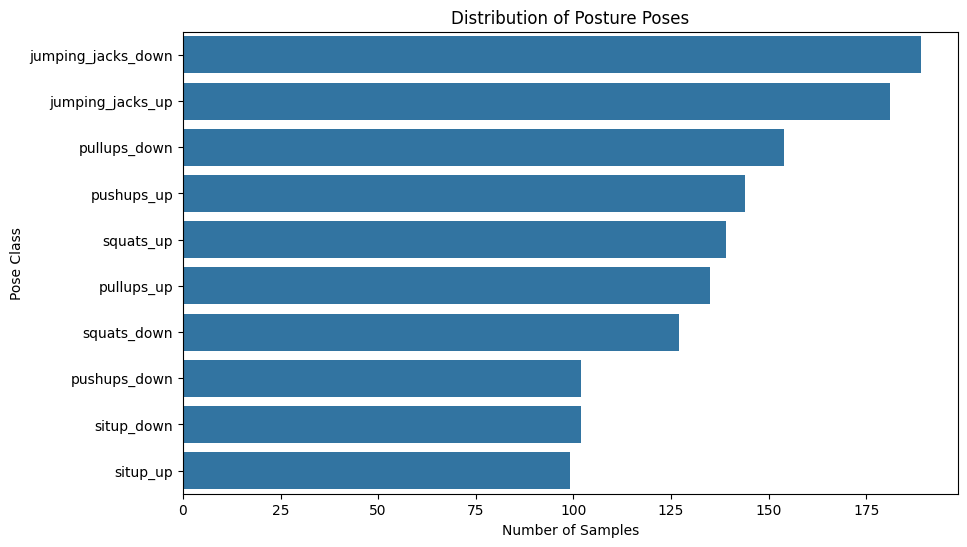

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(y='pose', data=df_master, order=df_master['pose'].value_counts().index)
plt.title('Distribution of Posture Poses')
plt.xlabel('Number of Samples')
plt.ylabel('Pose Class')
plt.show()

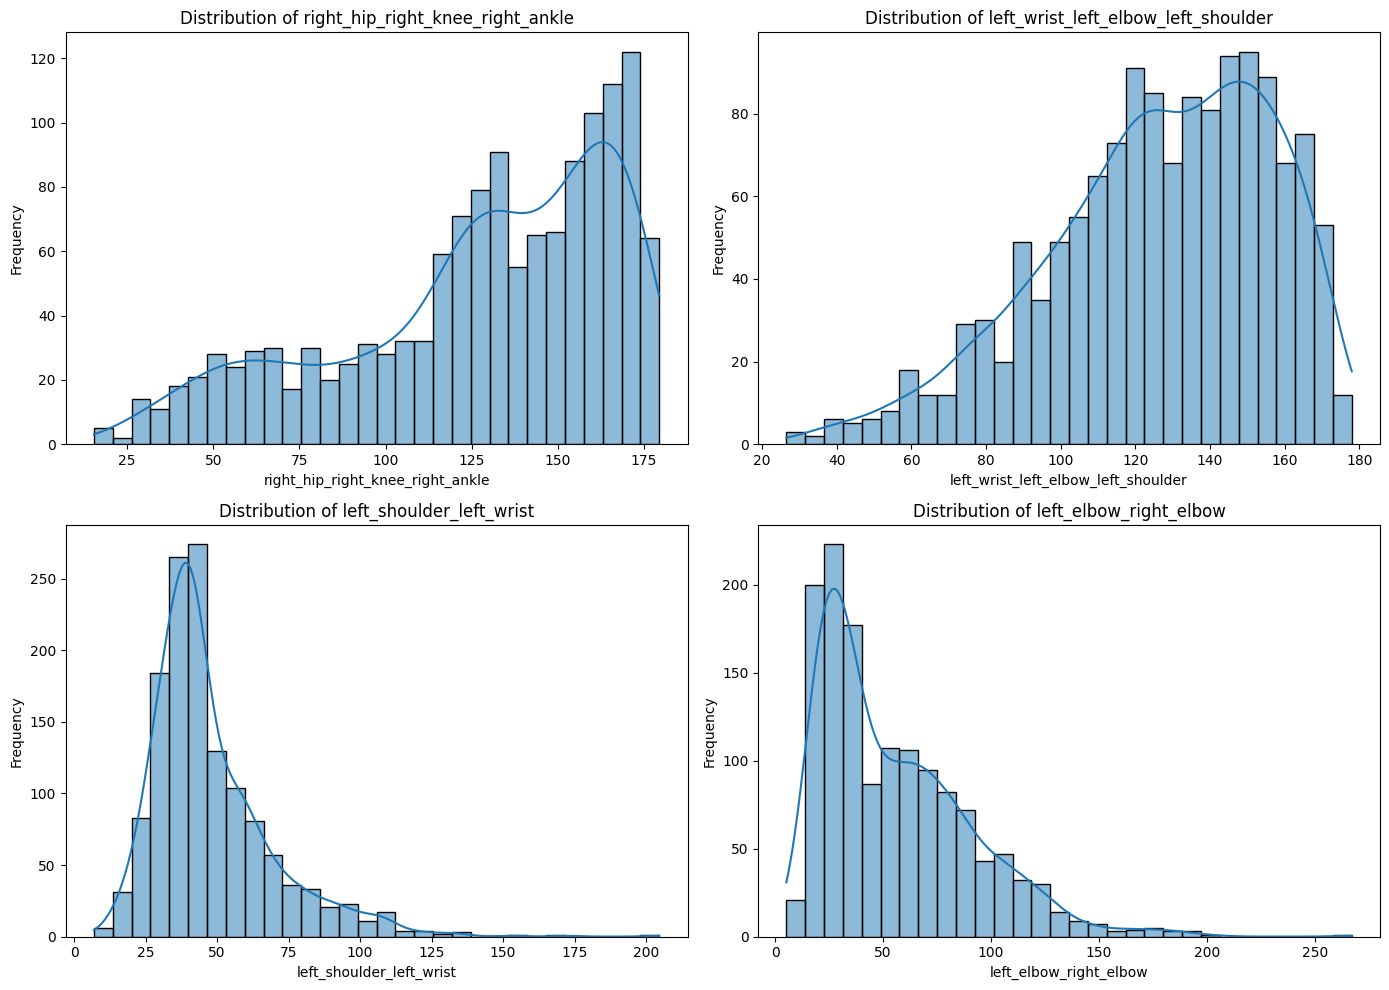

In [6]:
# Select a few features to visualize
features_to_plot = [
    'right_hip_right_knee_right_ankle', 
    'left_wrist_left_elbow_left_shoulder', 
    'left_shoulder_left_wrist', 
    'left_elbow_right_elbow'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.histplot(df_master[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

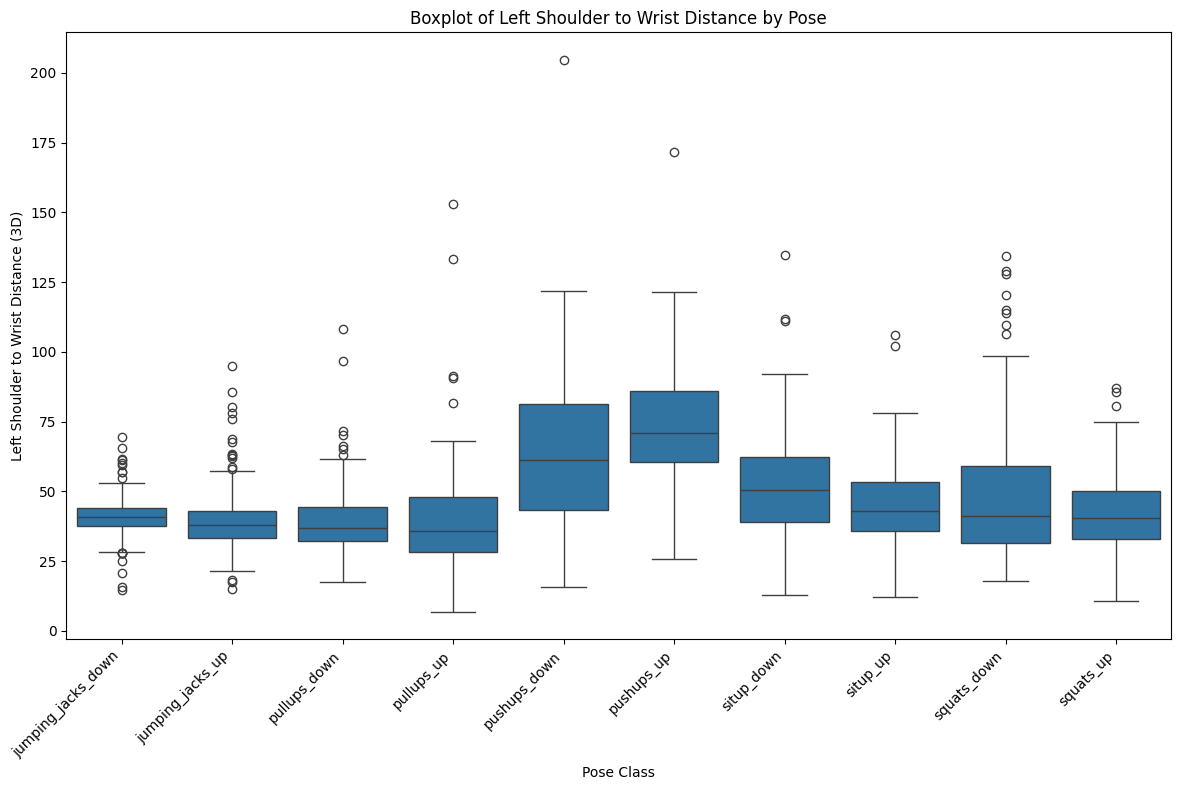

In [7]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='pose', y='left_shoulder_left_wrist', data=df_master)
plt.title('Boxplot of Left Shoulder to Wrist Distance by Pose')
plt.xlabel('Pose Class')
plt.ylabel('Left Shoulder to Wrist Distance (3D)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

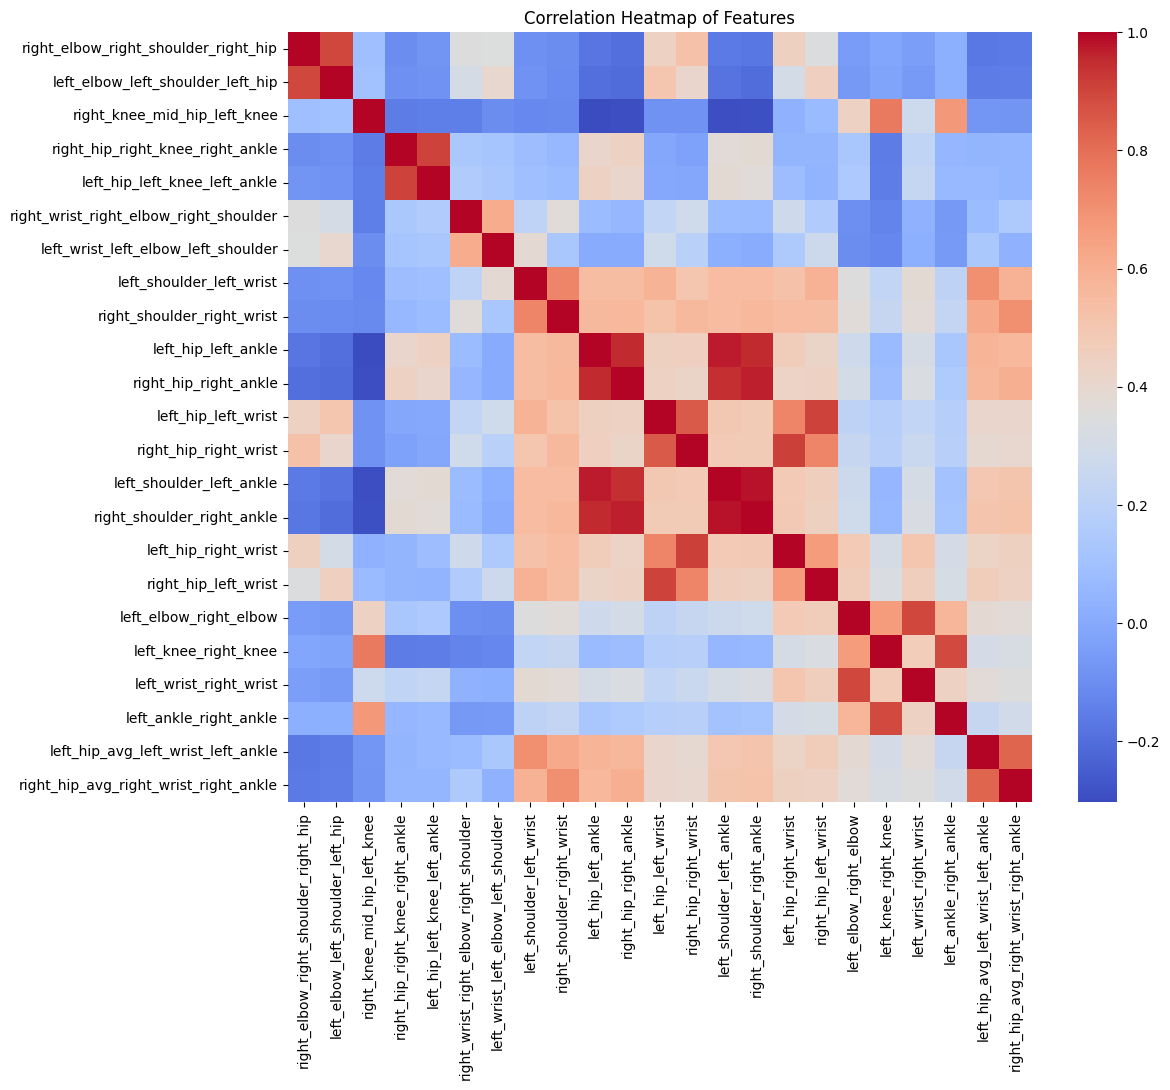

In [8]:
# Select a subset of numerical features for the heatmap
numerical_features = df_master.select_dtypes(include=np.number).columns.drop('pose_id')

# Calculate the correlation matrix
correlation_matrix = df_master[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

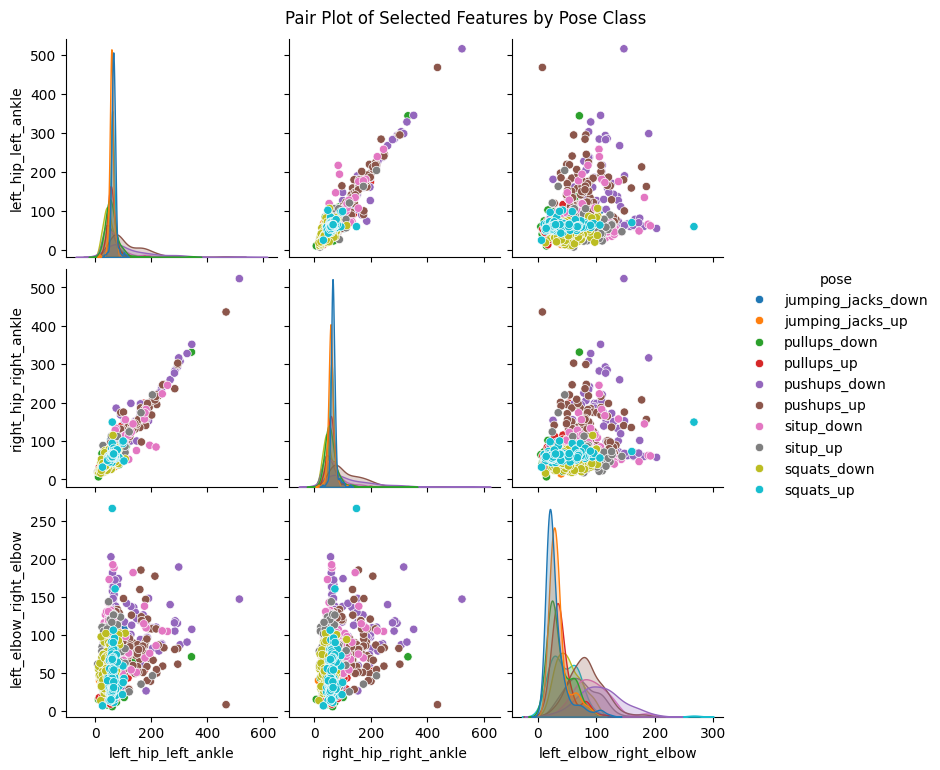

In [9]:
# Select a few features and the target for a pair plot
subset_for_pairplot = df_master[['left_hip_left_ankle', 'right_hip_right_ankle', 'left_elbow_right_elbow', 'pose']]
sns.pairplot(subset_for_pairplot, hue='pose', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features by Pose Class', y=1.02)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB # You mentioned Bayesian, GaussianNB is a simple Bayesian model
from sklearn.ensemble import RandomForestClassifier # A good baseline to compare with

# Drop the 'pose_id' column
df_model = df_master.drop('pose_id', axis=1)

# Separate features (X) and target (y)
X = df_model.drop('pose', axis=1)
y = df_model['pose']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
print("\n--- Training Logistic Regression ---")
log_reg_model = LogisticRegression(max_iter=1000, solver='lbfgs') # Increased max_iter for convergence
log_reg_model.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))


--- Training Logistic Regression ---
Logistic Regression Accuracy: 0.7418
Classification Report:
                    precision    recall  f1-score   support

jumping_jacks_down       0.71      0.84      0.77        38
  jumping_jacks_up       0.85      0.78      0.81        36
      pullups_down       0.77      0.74      0.75        31
        pullups_up       0.60      0.56      0.58        27
      pushups_down       0.90      0.90      0.90        20
        pushups_up       0.81      0.86      0.83        29
        situp_down       0.75      0.60      0.67        20
          situp_up       0.80      0.60      0.69        20
       squats_down       0.77      0.88      0.82        26
         squats_up       0.53      0.57      0.55        28

          accuracy                           0.74       275
         macro avg       0.75      0.73      0.74       275
      weighted avg       0.74      0.74      0.74       275



In [14]:
print("\n--- Training SVM ---")
svm_model = SVC(kernel='rbf', C=1.0) # Using a Radial Basis Function kernel
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))


--- Training SVM ---
SVM Accuracy: 0.7782
Classification Report:
                    precision    recall  f1-score   support

jumping_jacks_down       0.73      0.79      0.76        38
  jumping_jacks_up       0.83      0.81      0.82        36
      pullups_down       0.77      0.74      0.75        31
        pullups_up       0.70      0.59      0.64        27
      pushups_down       0.83      0.95      0.88        20
        pushups_up       0.90      0.93      0.92        29
        situp_down       0.82      0.70      0.76        20
          situp_up       0.94      0.75      0.83        20
       squats_down       0.80      0.92      0.86        26
         squats_up       0.57      0.61      0.59        28

          accuracy                           0.78       275
         macro avg       0.79      0.78      0.78       275
      weighted avg       0.78      0.78      0.78       275



In [15]:
print("\n--- Training Gaussian Naive Bayes ---")
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train) # Naive Bayes does not require scaling
y_pred_gnb = gnb_model.predict(X_test)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_gnb):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_gnb))


--- Training Gaussian Naive Bayes ---
Gaussian Naive Bayes Accuracy: 0.5964
Classification Report:
                    precision    recall  f1-score   support

jumping_jacks_down       0.65      0.79      0.71        38
  jumping_jacks_up       0.57      0.86      0.69        36
      pullups_down       0.60      0.19      0.29        31
        pullups_up       0.50      0.56      0.53        27
      pushups_down       0.78      0.70      0.74        20
        pushups_up       0.79      0.66      0.72        29
        situp_down       0.55      0.30      0.39        20
          situp_up       0.71      0.50      0.59        20
       squats_down       0.62      0.77      0.69        26
         squats_up       0.36      0.46      0.41        28

          accuracy                           0.60       275
         macro avg       0.61      0.58      0.57       275
      weighted avg       0.61      0.60      0.58       275



In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [20]:

# Define the base path to your dataset folder
base_path = r'C:\Users\abhis\ML-PROJECT\posture-correction\dataset'

# Construct the full paths to each CSV file
file_paths = {
    'labels': os.path.join(base_path, 'labels.csv'),
    'angles': os.path.join(base_path, 'angles.csv'),
    '3d_distances': os.path.join(base_path, '3d_distances.csv'),
    'xyz_distances': os.path.join(base_path, 'xyz_distances.csv'),
    'landmarks': os.path.join(base_path, 'landmarks.csv')
}

# --- Data Loading and Preparation ---

try:
    print("Loading and preparing data...")
    df_labels = pd.read_csv(file_paths['labels'])
    df_angles = pd.read_csv(file_paths['angles'])
    df_3d_distances = pd.read_csv(file_paths['3d_distances'])
    
    # Merge the datasets
    df_master = df_labels.copy()
    df_master = pd.merge(df_master, df_angles, on='pose_id', how='left')
    df_master = pd.merge(df_master, df_3d_distances, on='pose_id', how='left')
    
    # Drop the 'pose_id' and 'pose' columns from the features for clustering and PCA
    X = df_master.drop(['pose_id', 'pose'], axis=1)
    
    # Standardize the features - crucial for these algorithms
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Data loaded and standardized successfully.")
    print(f"Shape of the feature matrix: {X_scaled.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}. Please double-check the path to your dataset folder.")
    exit()


Loading and preparing data...
Data loaded and standardized successfully.
Shape of the feature matrix: (1372, 23)



--- K-Means Clustering ---


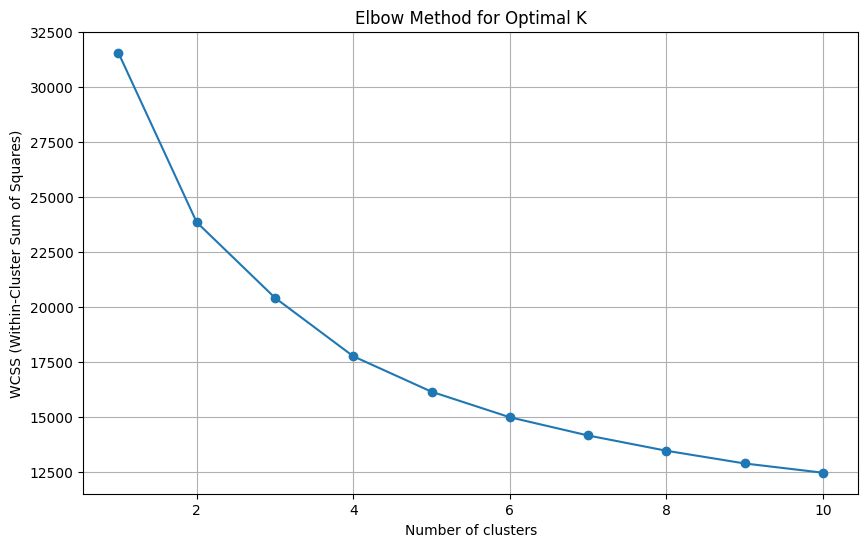

K-Means clustering with 3 clusters complete.
Silhouette Score for K-Means: 0.1898

--- Mixtures of Gaussians (GMM) ---
GMM clustering with 3 components complete.
Silhouette Score for GMM: 0.0893

--- Hierarchical Clustering (Dendrogram) ---


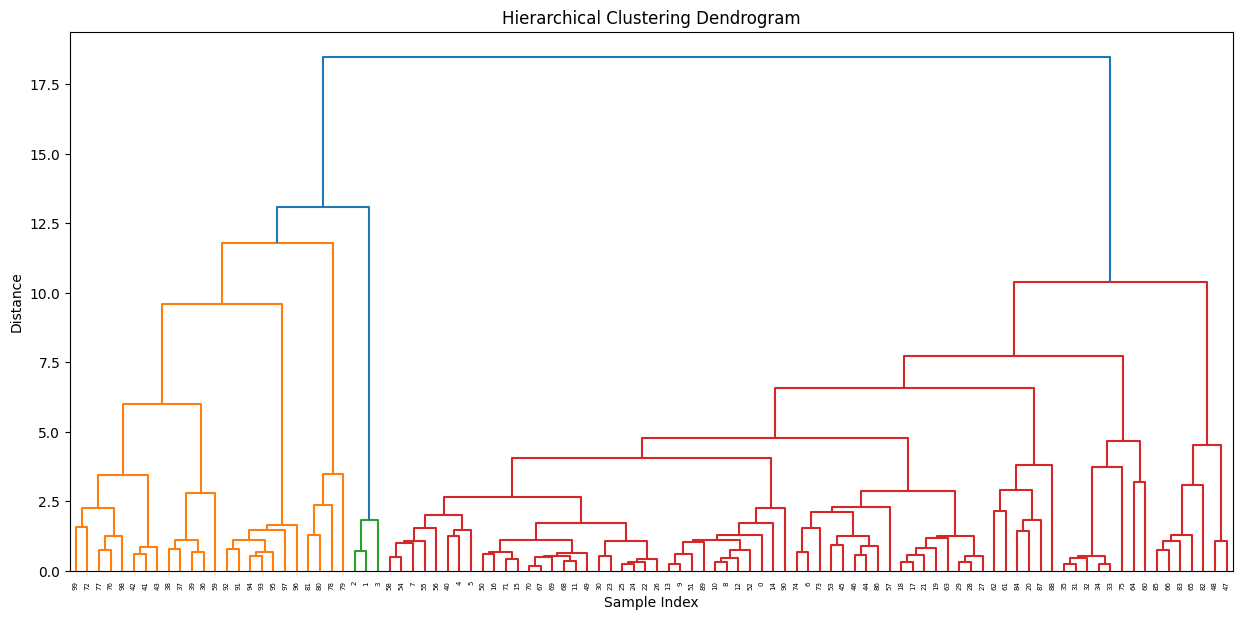

In [21]:

# --- Clustering Algorithms ---

# Determining the optimal number of clusters (K) using the Elbow Method
print("\n--- K-Means Clustering ---")
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Based on the elbow plot, let's assume an optimal K. We can choose 3 for demonstration.
# You should interpret the plot and choose the number of clusters where the decrease in WCSS slows down.
n_clusters_kmeans = 3
kmeans_model = KMeans(n_clusters=n_clusters_kmeans, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_scaled)
print(f"K-Means clustering with {n_clusters_kmeans} clusters complete.")
print(f"Silhouette Score for K-Means: {silhouette_score(X_scaled, kmeans_labels):.4f}")


print("\n--- Mixtures of Gaussians (GMM) ---")
# Fit GMM with a chosen number of components
n_components_gmm = 3
gmm_model = GaussianMixture(n_components=n_components_gmm, random_state=42)
gmm_labels = gmm_model.fit_predict(X_scaled)
print(f"GMM clustering with {n_components_gmm} components complete.")
print(f"Silhouette Score for GMM: {silhouette_score(X_scaled, gmm_labels):.4f}")


print("\n--- Hierarchical Clustering (Dendrogram) ---")
# Use a subset of the data for the dendrogram for better visualization
X_subset = X_scaled[:100, :]
linked = linkage(X_subset, 'ward')
plt.figure(figsize=(15, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


--- Performing Principal Component Analysis (PCA) ---


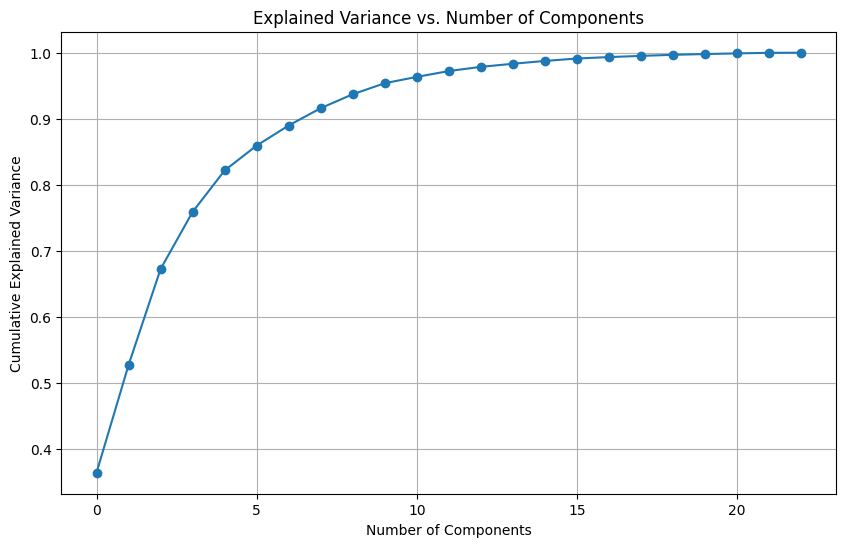

Number of components to explain 95% variance: 10

PCA successfully performed.
Original feature space dimension: 23
Reduced feature space dimension: 10
Reduced data (first 5 rows):
[[-2.78125041 -2.68793697 -0.31597421 -0.49097652  1.34188645  0.00463915
   0.29419016 -0.77219259 -0.25632134  0.15840961]
 [ 1.09622625  1.05446701 -1.76041254 -4.10513253  1.24889099  0.7809462
  -0.28435763  0.1718164  -0.48819286 -0.01358532]
 [ 1.51789584  1.33581385 -1.75709368 -4.39947888  1.27356119  0.95149372
  -0.1544541   0.45942836 -0.4198518   0.08912841]
 [ 0.65501565  0.51167256 -1.42997712 -3.287887    0.63624143  0.91163247
  -0.23510245  0.07756108 -0.59643771 -0.0907103 ]
 [-2.35116941 -2.62979512 -0.40564629 -0.31707958  0.01474164  0.59840066
   0.63277566 -0.09333066  0.21210702  0.06008729]]

--- Conclusion ---
The script has successfully performed the following:
- Data loading, merging, and standardization.
- K-Means clustering with a plot to find the optimal 'K'.
- Gaussian Mixture

In [22]:

# --- Principal Component Analysis (PCA) ---

print("\n--- Performing Principal Component Analysis (PCA) ---")
# First, let's determine the number of components
pca = PCA(n_components=None) # No n_components specified to get all components
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Now, we'll perform PCA with a specific number of components
# A common practice is to choose the number of components that explain 95% of the variance
n_components_pca = np.where(np.cumsum(explained_variance_ratio) >= 0.95)[0][0] + 1
print(f"Number of components to explain 95% variance: {n_components_pca}")

pca_model = PCA(n_components=n_components_pca)
X_pca = pca_model.fit_transform(X_scaled)

print("\nPCA successfully performed.")
print(f"Original feature space dimension: {X_scaled.shape[1]}")
print(f"Reduced feature space dimension: {X_pca.shape[1]}")
print("Reduced data (first 5 rows):")
print(X_pca[:5])

# You can now use X_pca as your new feature set for training supervised models.
# For example:
# X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, df_master['pose'], test_size=0.2, random_state=42)

# --- Summary and Conclusion ---
print("\n--- Conclusion ---")
print("The script has successfully performed the following:")
print("- Data loading, merging, and standardization.")
print("- K-Means clustering with a plot to find the optimal 'K'.")
print("- Gaussian Mixture Model (GMM) clustering.")
print("- Hierarchical Clustering visualized with a dendrogram.")
print("- Principal Component Analysis (PCA) to reduce dimensionality.")
print("The reduced PCA data is stored in the 'X_pca' variable.")